In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import modeling_tools as mt
import murmurhash as mhash

from sklearn.neural_network import MLPClassifier


from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances

In [12]:
labeled_data = pd.read_pickle('../../data/labeled_data_pos_ont_nn.pkl')
drop_trash = (labeled_data['Aggr.Label'] < 90) & (labeled_data['NN_bool'] == False)
labeled_data = labeled_data[drop_trash]

In [56]:
pos_features = ['Adjective', 'Verb', 'Noun']
ont_features = ['Underspecified', 'Artifact', 'Object', 'Group', 'Human', 'Natural', 'LanguageRepresentation', 'Living', 'GeopoliticalPlace', 'BodyPart', 'Instrument', 'Place', '3rdOrderEntity', 'Mental', 'Purpose', 'Social', 'Institution', 'Plant', 'Imagerepresentation', 'Creature', 'Animal', 'Comestible', 'Quantity', 'Building', 'Substance', 'Part', 'Property', 'BoundedEvent', 'Agentive', 'Communication', 'Garment', 'Furniture', 'Vehicle', '1stOrderEntity', 'Covering', 'Liquid', 'Time', 'UnboundedEvent', 'Physical', 'Dynamic', 'Domain', 'Existence', 'Location', 'Manner', 'Container', 'Condition', 'Static', '2ndOrderEntity', 'Phenomenal', 'MoneyRepresentation', 'Experience', 'Relation', 'Form', 'Representation', 'Stimulating', 'Colour', 'Cause', 'Occupation', 'Possession', 'Artwork', 'Software']
numerical_features = ['Raw_len', 'Raw_word_count']
categorical_features = ['Label', 'Aggr.Label', 'Source', 'CoderId']
text_features = ['Lemma_stripped', 'Raw', 'Lemma']
fastt_features = ['Raw_FT_mean', 'Lemma_FT_mean']
features = pos_features + ont_features + numerical_features + text_features + fastt_features + categorical_features

fastt = 'Raw_FT_mean'
corpus = 'Lemma'
#target = 'Aggr.Label'
target = 'Label'


train_X, validation_X, train_y, validation_y = train_test_split(
    labeled_data[features],
    labeled_data[target],
    test_size=0.33,
    random_state=1,
    stratify=labeled_data[target])

In [4]:
number_labels = labeled_data['Label'].unique().shape[0]
len_columns = labeled_data.shape[0]
num_classifiers = 4
num_buckets = round(number_labels/num_classifiers)

In [53]:
class BucketClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, hashfunc, classifiers, judge):
        self.num_classifiers = len(classifiers)
        self.hashfunc = hashfunc
        self.classifiers = classifiers
        self.judge = judge
 
    def fit(self, X, y):

        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        
        #self.num_buckets = round(len(self.classes_)/self.num_classifiers)
        #self.num_buckets = round(len(self.classes_)/5)
        self.num_buckets = 10
        self.buckets = [[] for _ in range(self.num_buckets)]

        bucketed = []

        for n in range(self.num_classifiers):
            bucketed.append([self.hashfunc.hash(str(yi+n))%self.num_buckets for yi in self.y_])
            for yu in self.classes_:
                b = self.hashfunc.hash(str(yu+n))%self.num_buckets
                self.buckets[b].append(yu)

        self.bucketed_ = bucketed
        
        self.bucketed_t_ = np.array(bucketed).T

        for ci in range(self.num_classifiers):
            self.classifiers[ci].fit(self.X_, self.bucketed_[ci])

            
        self.judge.fit(self.bucketed_t_, self.y_)

        return self

    def predict(self, X):

        bucket_preds = []
        
        for ci in range(self.num_classifiers):
            bucket_preds.append(self.classifiers[ci].predict(X))
        
        bucket_preds_t = np.array(bucket_preds).T
        
        '''
        preds = []

        for p in range(X.shape[0]):
            candidates = {}
            for b in bucket_preds_t[p]:
                for yu in self.buckets[b]:
                    if yu not in candidates:
                        candidates[yu] = 1
                    else:
                        candidates[yu] += 1
            sorted_candidates = sorted(candidates.items(), key=lambda kv: kv[1], reverse=True)
            preds.append(sorted_candidates[0])
            
            
        return [x for x,_ in preds]
        '''
        
        preds = self.judge.predict(bucket_preds_t)

        return preds

In [57]:
vectorizer = TfidfVectorizer()
train_x = vectorizer.fit_transform(train_X[corpus])
validation_x = vectorizer.transform(validation_X[corpus])

In [59]:
classifiers = [MultinomialNB(alpha=0.001) for _ in range(10)]
first_bucket = BucketClassifier(mhash, classifiers, MultinomialNB(alpha=0.001))

first_bucket.fit(train_x, train_y)
preds = first_bucket.predict(validation_x)
np.mean(preds == validation_y)


0.39051618189266696

In [74]:
testy = {1: 3, 2:4, 3:5}
[x for x,_ in sorted(testy.items(), key=lambda kv: kv[1], reverse=True)]

[3, 2, 1]

In [72]:
preds

[(3, 6),
 (2, 4),
 (3, 5),
 (4, 6),
 (4, 4),
 (4, 4),
 (10, 4),
 (2, 6),
 (12, 6),
 (12, 4),
 (4, 6),
 (4, 4),
 (9, 6),
 (21, 4),
 (3, 6),
 (4, 4),
 (19, 6),
 (12, 5),
 (12, 6),
 (12, 6),
 (3, 6),
 (3, 6),
 (4, 6),
 (3, 6),
 (12, 6),
 (4, 6),
 (4, 5),
 (10, 6),
 (12, 6),
 (10, 6),
 (2, 5),
 (10, 4),
 (6, 5),
 (2, 6),
 (10, 4),
 (21, 6),
 (20, 6),
 (21, 7),
 (10, 6),
 (20, 5),
 (4, 6),
 (21, 6),
 (21, 4),
 (10, 5),
 (10, 4),
 (3, 7),
 (6, 6),
 (12, 6),
 (4, 6),
 (6, 5),
 (2, 6),
 (21, 7),
 (4, 4),
 (10, 4),
 (21, 6),
 (4, 4),
 (4, 4),
 (12, 6),
 (3, 6),
 (3, 6),
 (4, 6),
 (10, 4),
 (21, 7),
 (14, 4),
 (21, 6),
 (14, 4),
 (4, 4),
 (3, 6),
 (21, 7),
 (12, 6),
 (20, 5),
 (21, 6),
 (3, 6),
 (3, 5),
 (19, 5),
 (2, 6),
 (6, 6),
 (19, 6),
 (14, 4),
 (4, 4),
 (4, 4),
 (12, 6),
 (12, 6),
 (17, 6),
 (4, 6),
 (4, 6),
 (3, 6),
 (10, 4),
 (17, 7),
 (2, 6),
 (21, 7),
 (6, 5),
 (12, 6),
 (4, 4),
 (21, 7),
 (10, 7),
 (20, 5),
 (3, 6),
 (12, 6),
 (6, 6),
 (10, 5),
 (10, 6),
 (12, 6),
 (6, 5),
 (21, 6),


In [39]:
testy = np.array([[1,2,3],[1,2,3],[1,2,3]]).T
testy[0]

array([1, 1, 1])

In [27]:
original = [1601, 12, 12, 16, 401, 12, 2002, 3, 23, 4, 14, 5, 3, 3, 12]
hashed = [mhash.hash(str(x+6))%4 for x in original]
unique_labels(hashed)


array([0, 1, 2, 3])

In [7]:
import random

_memomask = {}

def hash_function(n):
  mask = _memomask.get(n)
  if mask is None:
    random.seed(n)
    mask = _memomask[n] = random.getrandbits(32)
  def myhash(x):
    return hash(x) ^ mask
  return myhash

def uni_hashing(family, tohash, num_buckets):
    return (hash(tohash) + family) % num_buckets

In [13]:
[hash_function(2)(str(x)) % num_buckets for x in labeled_data['Label'].values][5]

6

In [25]:
#print(list(labeled_data['Label'].values))

In [35]:
for r in range(num_classifiers):
    title = 'R_'+str(r)
    labeled_data[title] = [hash_function(r)(str(x)) % num_buckets for x in labeled_data['Label'].values]

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [60]:
labeled_data['Label'].unique()[0]

1601

In [36]:
labeled_data.groupby('R_0')['R_0'].count()

R_0
1      591
2       17
3     6807
4     3480
5     3182
6     4597
7     5338
9     2402
10    3181
11     674
12     930
13    2880
14     958
15    2286
Name: R_0, dtype: int64

In [37]:
train_X, validation_X, train_y, validation_y = train_test_split(
    labeled_data['Lemma_stripped'],
    labeled_data['Label'],
    test_size=0.33,
    random_state=1,
    stratify=labeled_data['Label'])

In [38]:
vectorizer = TfidfVectorizer()
train_x = vectorizer.fit_transform(train_X)
validation_x = vectorizer.transform(validation_X)

In [10]:
labeled_data.loc[train_y.index]['R_0']

683703     0
94274      6
742138     4
1522467    7
281704     1
          ..
1549589    8
278322     6
138879     7
794972     7
987916     8
Name: R_0, Length: 25006, dtype: int64

In [39]:
preds = []
for c in range(num_classifiers):
    r = 'R_'+str(c)
    p = 'P_'+str(c)
    model = MultinomialNB(alpha=0.001)
    model.fit(train_x, labeled_data.loc[train_y.index][r])
    preds.append(model.predict(validation_x))
    acc = accuracy_score(labeled_data.loc[validation_y.index][r], preds[c])
    prec, reca, fsco, _ = precision_recall_fscore_support(labeled_data.loc[validation_y.index][r], preds[c], average='macro')
    print(acc, prec, reca, fsco)

C:\Users\nils\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4371194284322481 0.4128708831915428 0.34559036644777963 0.3635398646412365


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4371194284322481 0.41287088319154275 0.34559036644777963 0.36353986464123655


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4371194284322481 0.4128708831915428 0.34559036644777963 0.3635398646412365


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4371194284322481 0.4128708831915428 0.34559036644777963 0.3635398646412365


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4371194284322481 0.41287088319154275 0.3455903664477796 0.36353986464123655
0.4371194284322481 0.41287088319154275 0.34559036644777963 0.36353986464123655


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
bucket_label_map = {}

for r in range(num_classifiers):
    title = 'R_'+str(r)
    bucket_label_map[title] = []
    for b in range(num_buckets):
        bucket_label_map[title].append(list(labeled_data[labeled_data[title] == b]['Label'].unique()))
bucket_label_map


{'R_0': [[],
  [24],
  [1401],
  [10, 17, 21, 901, 501, 93],
  [15, 102, 103, 2501, 26],
  [2002, 14, 7, 1901],
  [12, 1001, 1902, 101],
  [1601, 3, 4, 1302, 6, 25],
  [],
  [9, 92, 104],
  [401, 91],
  [20, 1903],
  [19, 1301],
  [5, 8, 1, 2001, 2, 18],
  [23],
  [16, 13]],
 'R_1': [[],
  [9, 92, 104],
  [401, 91],
  [20, 1903],
  [19, 1301],
  [5, 8, 1, 2001, 2, 18],
  [23],
  [16, 13],
  [],
  [24],
  [1401],
  [10, 17, 21, 901, 501, 93],
  [15, 102, 103, 2501, 26],
  [2002, 14, 7, 1901],
  [12, 1001, 1902, 101],
  [1601, 3, 4, 1302, 6, 25]],
 'R_2': [[23],
  [16, 13],
  [19, 1301],
  [5, 8, 1, 2001, 2, 18],
  [401, 91],
  [20, 1903],
  [],
  [9, 92, 104],
  [12, 1001, 1902, 101],
  [1601, 3, 4, 1302, 6, 25],
  [15, 102, 103, 2501, 26],
  [2002, 14, 7, 1901],
  [1401],
  [10, 17, 21, 901, 501, 93],
  [],
  [24]],
 'R_3': [[],
  [24],
  [1401],
  [10, 17, 21, 901, 501, 93],
  [15, 102, 103, 2501, 26],
  [2002, 14, 7, 1901],
  [12, 1001, 1902, 101],
  [1601, 3, 4, 1302, 6, 25],
  [],


In [41]:
candidate_classes = [[] for _ in range(len(preds[0]))]
listed_y = list(validation_y)
for p in range(len(preds)):
    title = 'R_'+str(p)
    for pred in range(len(preds[p])):
        #if listed_y[pred] in bucket_label_map[title][preds[p][pred]]:
            #candidate_classes[pred].append(listed_y[pred])
        candidate_classes[pred] += bucket_label_map[title][preds[p][pred]]
                                          
candidate_classes 

[[10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93],
 [10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93],
 [10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93,
  10,
  17,
  21,
  901,
  501,
  93],
 [12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,
  101],
 [12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,
  101,
  12,
  1001,
  1902,


In [42]:
agg_result = []
for p in candidate_classes:
    if len(p) > 0:
        agg_result.append(max(set(p), key = p.count))
        #print(max(p, key = p.count))
        #break
    else:
        agg_result.append(12)
np.mean(agg_result == validation_y)

0.08183810992936592

(45, 45)


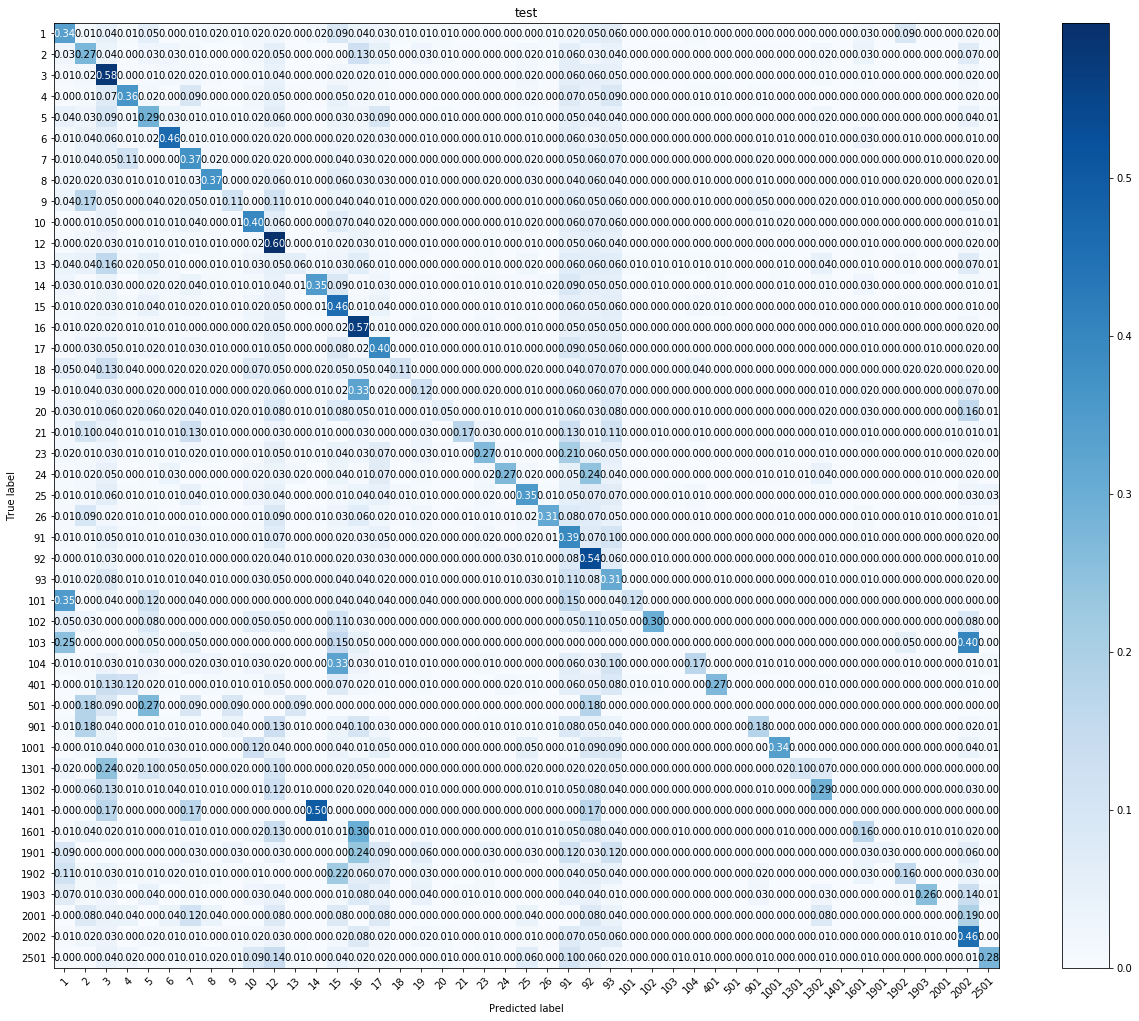

In [33]:
testy = mt.plot_cf(validation_y, agg_result, title = 'test')

In [23]:
np.mean(preds[0] == labeled_data.loc[validation_y.index]['R_0'])
labeled_data.loc[validation_y.index]

,Id,Label,Pub.Date,Source,CoderId,Aggr.Label,Raw,Lemma,Raw_len,Raw_word_count,Lemma_FT_mean,Lemma_stripped,R_0,R_1,R_2,R_3
1416891,2dXPbmABVo8DrD4XcPv8,7,2012-11-26 03:00:00,VG,1,7,Langreist søppel. I en artikkel (Aftenposten 1...,Langreist søppel $. i en artikkel $( Aftenpost...,707,119,"[-0.14428794978533027, -0.052039982534425204, ...",Langreist søppel i en artikkel Aftenposten 1...,3,2,7,3
510391,8tLObmABVo8DrD4XOIZi,15,2008-10-13 02:00:00,VG,2,15,SPAR STORT med m ange små kutt. Du kan faktisk...,Spar stort med m. ang liten kutt $. du kunne f...,1158,218,"[-0.1972977103884832, -0.01920406367198741, -0...",Spar stort med m. ang liten kutt du kunne fak...,6,0,9,8
258215,2rzEbmABVo8DrD4XG1YK,91,2003-09-14 02:00:00,Aftenposten,3,91,springbrett Pia Tjelta (26) skuespillerinne En...,springbrett Pia Tjelta $( 26 $) skuespillerinn...,2944,531,"[-0.22200436862978645, -0.035988738299266125, ...",springbrett Pia Tjelta 26 skuespillerinne en...,9,1,3,9
432550,l77FbmABVo8DrD4XGfNP,15,2006-10-04 02:00:00,Aftenposten,2,15,Kjendisadvokat anmeldt for trusler. Knusing av...,Kjendisadvokat anmelde for trussel $. Knusing ...,725,119,"[-0.3086507444748202, 0.015635705716605927, 0....",Kjendisadvokat anmelde for trussel Knusing av...,6,0,9,8
380547,j87MbmABVo8DrD4XgFhH,12,2003-07-20 02:00:00,VG,3,12,Drapstruet. STAVANGER (VG) Krangelen mellom ba...,Drapstru $. Stavanger $( VG $) Krangel mellom ...,363,55,"[-0.19194945502316668, -0.031093918940141088, ...",Drapstru Stavanger VG Krangel mellom badere...,2,10,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486813,Ns7MbmABVo8DrD4Xwf_y,12,2004-07-04 02:00:00,VG,2,12,Norskættet mann (56). MYSTISK DØD Britisk poli...,Norskættet mann $( 56 $) $. mystisk død britis...,2745,465,"[-0.147961172001779, -0.040320396841776046, 0....",Norskættet mann 56 mystisk død britisk poli...,2,10,8,2
902511,EMPHbmABVo8DrD4XUrHn,15,2011-03-22 03:00:00,Aftenposten,2,15,Setter ny cruiserekord. Antall planlagte cruis...,sette ny cruiserekord $. antall planlinge crui...,562,89,"[-0.1312644500285387, -0.15061910021240296, -0...",sette ny cruiserekord antall planlinge cruise...,6,0,9,8
1185773,v8PHbmABVo8DrD4XLD5q,3,2011-10-14 02:00:00,Aftenposten,2,3,Rammer flest og koster mest. Ryggplager. Muske...,ramme mange og koste mye $. Ryggplager $. musk...,2554,348,"[-0.2154582703835331, -0.0360061929128798, 0.0...",ramme mange og koste mye Ryggplager muskel o...,8,9,3,7
972286,79fPbmABVo8DrD4X-yaT,91,2013-04-02 02:00:00,VG,1,91,GIKK DU PÅ SPØKEN? En rekke medier og firmaer ...,gå du På SPØKEN $? en rekke medium og firma ko...,2864,467,"[-0.23064070605714596, -0.04990932872386844, 0...",gå du På SPØKEN en rekke medium og firma kost...,9,1,3,9
